In [1]:
%pip install -U pm4py tqdm

import pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.1 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=41cc220e7e963385b0de3e773c928c5660b23cd6b53600a33207514e0fa09206
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [2]:
# If using Google Colab, mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

CASE_NAME = "case:concept:name"
ACTIVITY_NAME = "concept:name"
TIMESTAMP_NAME = "time:timestamp"

BASE_PATH = "/content/drive/MyDrive/Experimento"
df_1 = pd.read_csv(f"{BASE_PATH}/juizado_1.csv")
df_2 = pd.read_csv(f"{BASE_PATH}/juizado_2.csv")
df_3 = pd.read_csv(f"{BASE_PATH}/juizado_3.csv")
df_1.shape, df_2.shape, df_3.shape

((235620, 5), (239546, 5), (237302, 5))

In [4]:
from sklearn.preprocessing import MaxAbsScaler

def get_activity_profile(df: pd.DataFrame):
  activity_profile = df.groupby([CASE_NAME, ACTIVITY_NAME]).size().unstack(fill_value=0)

  scaler = MaxAbsScaler()
  scaler.fit(activity_profile)
  df_scaled = scaler.transform(activity_profile)

  return pd.DataFrame(df_scaled, columns=activity_profile.columns,
                      index=activity_profile.index)

ap_1 = get_activity_profile(df_1)
ap_2 = get_activity_profile(df_2)
ap_3 = get_activity_profile(df_3)

ap_1.shape, ap_2.shape, ap_3.shape

((7683, 101), (8301, 90), (7559, 96))

In [7]:
from sklearn.cluster import DBSCAN, HDBSCAN, AgglomerativeClustering, KMeans
from itertools import product
import numpy as np
import math

def generate_HDBSCAN_search_space(limite, learn_rate, learn_rate_deviation):
    """
    Gera uma sequência de números representando o espaço de busca do parâmetro "min_cluster_size" do HDBSCAN.

    Esta função gera uma sequência de valores que diminui progressivamente, com base em um valor inicial calculado
    a partir de uma fração de `limite`. Os valores são decrementados de acordo com uma taxa de aprendizado
    ajustável (`learn_rate`), que aumenta ao longo do tempo por uma quantidade especificada
    (`learn_rate_deviation`). Isso pode ser utilizado, por exemplo, para definir um intervalo de valores
    de `min_cluster_size` ou `min_samples` na otimização de parâmetros do HDBSCAN.

    Parâmetros:
    -----------
    limite : int
        O limite superior para calcular o valor máximo inicial. O valor inicial é baseado
        em uma fração (5%) desse `limite`, ajustado em 50% para cima.

    learn_rate : float
        A taxa inicial com a qual o valor é reduzido em cada iteração.

    learn_rate_deviation : float
        A quantidade pela qual o `learn_rate` é aumentado após cada iteração, permitindo
        decrementos progressivamente maiores nos valores gerados.

    Retorna:
    --------
    numeros : lista de int
        Uma lista de valores inteiros, cada um representando um valor progressivamente menor,
        gerado ao decrementar o valor máximo de acordo com a dinâmica da taxa de aprendizado.

    """
    numeros = []

    max_val = limite*0.05
    max_val += max_val*0.5
    max_val = math.floor(max_val)

    learn_rate = learn_rate
    val = max_val
    while val > 0:
        numeros.append(val)
        val = math.floor(val - max_val*learn_rate)
        learn_rate += learn_rate_deviation

    return numeros

def get_models_and_configs(activity_profile: pd.DataFrame):
  min_cluster_size_vals = generate_HDBSCAN_search_space(
      len(activity_profile), 0.001, 0.001)

  n_clusters_range_kmeans = range(2, 51, 1)
  n_clusters_range_agglomerative = range(2, 51, 1)

  upper_bound = math.sqrt(len(activity_profile.columns.to_list()))/6
  lower_bound = upper_bound * 0.05
  eps_values = np.arange(upper_bound, lower_bound, -0.01)

  configs = {
      'K-means': {'n_clusters': n_clusters_range_kmeans},
      'DBSCAN': {'eps': eps_values, 'min_samples': [5, 10], "n_jobs": [-1]},
      'AGGLC': {'n_clusters': n_clusters_range_agglomerative, 'linkage': ['ward']},
      'HDBSCAN': {'min_cluster_size': min_cluster_size_vals, "n_jobs": [-1]}
  }

  models = {
      'K-means': KMeans,
      'DBSCAN': DBSCAN,
      'AGGLC': AgglomerativeClustering,
      'HDBSCAN': HDBSCAN
  }

  return models, configs

def get_all_combinations(param_ranges: dict):
  """
  Gets all combinations of parameters from the provided configs dictionary.

  Args:
      configs: A dictionary where keys are arguments for the algorithm and values
      are lists of parameters to try for that argument.

  Returns:
      A list of dictionaries, where each dictionary represents a unique
      combination of parameters for a given algorithm.
  """
  all_combinations = []
  for combination in product(*param_ranges.values()):
    param_dict = dict(zip(param_ranges.keys(), combination))
    all_combinations.append(param_dict)
  return all_combinations

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score

def get_valid_silhouette_scores(dataframe, cluster_labels, threshold):
  silhouette_vals = silhouette_samples(dataframe, cluster_labels)

  clusters_info = []
  repr_sil_score = []
  for cluster in filter(lambda x: x != -1, set(cluster_labels)):
    cluster_points = cluster_labels == cluster
    num_points = sum(cluster_points)
    avg_silhouette_cluster = silhouette_vals[cluster_points].mean()

    clusters_info.append({
        'num_points': num_points,
        'avg_silhouette': avg_silhouette_cluster
    })

    if num_points > threshold: # Verifica se o cluster é "representativo"
        repr_sil_score.append(avg_silhouette_cluster)
  return clusters_info, repr_sil_score

def run_model_over_config(model_name, model_factory, config,
                          dataframe, threshold):
    linkage = config.get("linkage")
    max_distance = config.get("eps")
    min_samples = config.get("min_samples")
    min_cluster_size = config.get("min_cluster_size")

    model = model_factory(**config)
    cluster_labels = model.fit_predict(dataframe)

    clusters_info = None
    silhouette_avg = None
    repr_clusters_amount = 0
    avg_repr_silhouette_score = None
    num_clusters = len(list(filter(lambda x: x != -1, set(cluster_labels))))
    if num_clusters > 1:
      silhouette_avg = silhouette_score(dataframe, cluster_labels)
      clusters_info, repr_sil_score = get_valid_silhouette_scores(
          dataframe, cluster_labels, threshold)
      repr_clusters_amount = len(repr_sil_score)
      if repr_clusters_amount > 1:
        avg_repr_silhouette_score = sum(repr_sil_score) / repr_clusters_amount

      return {
          'algo': model_name,
          'linkage': linkage,
          'eps': max_distance,
          'clusters': clusters_info,
          'min_samples': min_samples,
          'num_clusters': num_clusters,
          'silhouette_score': silhouette_avg,
          'min_cluster_size': min_cluster_size,
          'num_representative_clusters': repr_clusters_amount,
          'silhouette_score_representative_clusters': avg_repr_silhouette_score
      }

In [35]:
from tqdm import tqdm
from math import isnan

def get_cluster_info(row):
  clusters = row['num_clusters']
  repr_clusters = row['num_representative_clusters']
  cluster_info = f"Clusters {repr_clusters}/{clusters}"
  
  min_cluster_size = row['min_cluster_size']
  if not isnan(min_cluster_size):
    cluster_info += f" | Cluster Size {min_cluster_size}"
  eps = row['eps']
  if not isnan(eps):
    cluster_info += f" | Eps: {round(eps, 2)}"
  linkage = row['linkage']
  if linkage is not None:
    cluster_info += f" | Linkage: {linkage}"
  samples = row['min_samples']
  if not isnan(samples):
    cluster_info += f" | Samples: {samples}"
  return cluster_info

def get_top_params_per_algo(df_name: str, activity_profile: pd.DataFrame):
  models, configs = get_models_and_configs(activity_profile)

  # Colect the results to each parameter
  results = []
  silhouette_thresh = 0.05 * len(activity_profile)

  for model_name, model in models.items():
      config_list = get_all_combinations(configs[model_name])
      print(f"{model_name} with {len(config_list)} combinations.")
      for config in tqdm(config_list, total=len(config_list)):
        model_results = run_model_over_config(model_name, model, config,
                                    activity_profile, silhouette_thresh)
        if model_results: results.append(model_results)

  # Save the results
  results_df = pd.DataFrame(results).sort_values(
      by='silhouette_score', ascending=False
  )
  results_df.to_csv(f"{BASE_PATH}/{df_name}_results.csv", index=False)

  # Select the 5 biggest ones and add a column to params and name
  results_df['params'] = results_df.apply(lambda row: get_cluster_info(row), axis=1)
  top_5_params_per_algo = results_df.groupby('algo').apply(
      lambda group: group.nlargest(5, [
          'silhouette_score_representative_clusters',
          'num_representative_clusters'
      ])
  ).reset_index(drop=True)
  top_5_params_per_algo.rename(columns={
      'silhouette_score_representative_clusters': 'best_silhouette'
  }, inplace=True)
  top_5_params_per_algo["unidade"] = df_name

  return top_5_params_per_algo

In [12]:
juizado_1 = get_top_params_per_algo("juizado_1", ap_1)
juizado_2 = get_top_params_per_algo("juizado_2", ap_2)
juizado_3 = get_top_params_per_algo("juizado_3", ap_3)

juizado_1.shape, juizado_2.shape, juizado_3.shape

K-means with 49 combinations.


100%|██████████| 49/49 [00:59<00:00,  1.21s/it]


DBSCAN with 320 combinations.


100%|██████████| 320/320 [05:53<00:00,  1.10s/it]


AGGLC with 49 combinations.


100%|██████████| 49/49 [02:58<00:00,  3.65s/it]


HDBSCAN with 44 combinations.


100%|██████████| 44/44 [05:28<00:00,  7.47s/it]
<ipython-input-11-5fa24d368cd2>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_params_per_algo = results_df.groupby('algo').apply(


K-means with 49 combinations.


100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


DBSCAN with 302 combinations.


100%|██████████| 302/302 [06:15<00:00,  1.24s/it]


AGGLC with 49 combinations.


100%|██████████| 49/49 [03:13<00:00,  3.95s/it]


HDBSCAN with 44 combinations.


100%|██████████| 44/44 [05:47<00:00,  7.90s/it]
<ipython-input-11-5fa24d368cd2>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_params_per_algo = results_df.groupby('algo').apply(


K-means with 49 combinations.


100%|██████████| 49/49 [00:56<00:00,  1.15s/it]


DBSCAN with 312 combinations.


100%|██████████| 312/312 [05:15<00:00,  1.01s/it]


AGGLC with 49 combinations.


100%|██████████| 49/49 [02:42<00:00,  3.31s/it]


HDBSCAN with 44 combinations.


100%|██████████| 44/44 [04:27<00:00,  6.09s/it]
<ipython-input-11-5fa24d368cd2>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_params_per_algo = results_df.groupby('algo').apply(


((20, 12), (20, 12), (20, 12))

In [36]:
all_top_5 = pd.concat([juizado_1, juizado_2, juizado_3]).sort_values(
    by=['best_silhouette', 'algo', 'params'], ascending=False
)
all_top_5

algo linkage       eps  \
10  HDBSCAN    None       NaN   
11  HDBSCAN    None       NaN   
12  HDBSCAN    None       NaN   
13  HDBSCAN    None       NaN   
10  HDBSCAN    None       NaN   
11  HDBSCAN    None       NaN   
13  HDBSCAN    None       NaN   
12  HDBSCAN    None       NaN   
14  HDBSCAN    None       NaN   
14  HDBSCAN    None       NaN   
10  HDBSCAN    None       NaN   
11  HDBSCAN    None       NaN   
12  HDBSCAN    None       NaN   
13  HDBSCAN    None       NaN   
14  HDBSCAN    None       NaN   
5    DBSCAN    None  1.014979   
5    DBSCAN    None  0.082993   
6    DBSCAN    None  1.032993   
7    DBSCAN    None  1.042993   
8    DBSCAN    None  1.052993   
6    DBSCAN    None  0.114979   
15  K-means    None       NaN   
9    DBSCAN    None  0.092993   
7    DBSCAN    None  0.124979   
5    DBSCAN    None  0.091139   
8    DBSCAN    None  0.184979   
6    DBSCAN    None  0.101139   
9    DBSCAN    None  0.114979   
16  K-means    None       NaN   
17  K-means    None       NaN   
15  K-means    None       NaN   
16  K-means    None       NaN   
18  K-means    None       NaN   
17  K-means    None       NaN   
7    DBSCAN    None  0.971139   
8    DBSCAN    None  0.961139   
9    DBSCAN    None  0.991139   
18  K-means    None       NaN   
19  K-means    None       NaN   
19  K-means    None       NaN   
0     AGGLC    ward       NaN   
0     AGGLC    ward       NaN   
1     AGGLC    ward       NaN   
2     AGGLC    ward       NaN   
3     AGGLC    ward       NaN   
4     AGGLC    ward       NaN   
1     AGGLC    ward       NaN   
2     AGGLC    ward       NaN   
3     AGGLC    ward       NaN   
4     AGGLC    ward       NaN   
0     AGGLC    ward       NaN   
1     AGGLC    ward       NaN   
2     AGGLC    ward       NaN   
4     AGGLC    ward       NaN   
3     AGGLC    ward       NaN   
15  K-means    None       NaN   
16  K-means    None       NaN   
17  K-means    None       NaN   
18  K-means    None       NaN   
19  K-means    None       NaN   

                                             clusters  min_samples  \
10  [{'num_points': 1359, 'avg_silhouette': 0.5282...          NaN   
11  [{'num_points': 838, 'avg_silhouette': 0.44985...          NaN   
12  [{'num_points': 1363, 'avg_silhouette': 0.5265...          NaN   
13  [{'num_points': 1365, 'avg_silhouette': 0.5258...          NaN   
10  [{'num_points': 795, 'avg_silhouette': 0.48743...          NaN   
11  [{'num_points': 744, 'avg_silhouette': 0.51830...          NaN   
13  [{'num_points': 745, 'avg_silhouette': 0.51795...          NaN   
12  [{'num_points': 745, 'avg_silhouette': 0.51795...          NaN   
14  [{'num_points': 746, 'avg_silhouette': 0.51753...          NaN   
14  [{'num_points': 848, 'avg_silhouette': 0.43772...          NaN   
10  [{'num_points': 1699, 'avg_silhouette': 0.4050...          NaN   
11  [{'num_points': 1700, 'avg_silhouette': 0.4048...          NaN   
12  [{'num_points': 1701, 'avg_silhouette': 0.4047...          NaN   
13  [{'num_points': 1701, 'avg_silhouette': 0.4047...          NaN   
14  [{'num_points': 1701, 'avg_silhouette': 0.4047...          NaN   
5   [{'num_points': 7541, 'avg_silhouette': 0.5031...         10.0   
5   [{'num_points': 190, 'avg_silhouette': 0.58209...         10.0   
6   [{'num_points': 7479, 'avg_silhouette': 0.4836...          5.0   
7   [{'num_points': 7485, 'avg_silhouette': 0.4831...          5.0   
8   [{'num_points': 7491, 'avg_silhouette': 0.4825...          5.0   
6   [{'num_points': 67, 'avg_silhouette': 0.678629...         10.0   
15  [{'num_points': 186, 'avg_silhouette': 0.05003...          NaN   
9   [{'num_points': 200, 'avg_silhouette': 0.55478...         10.0   
7   [{'num_points': 74, 'avg_silhouette': 0.655653...         10.0   
5   [{'num_points': 1326, 'avg_silhouette': 0.3489...         10.0   
8   [{'num_points': 809, 'avg_silhouette': 0.37618...         10.0   
6   [{'num_points': 1347, 'avg_silhouette': 0.3415...         10.0   
9   [{'num_points': 74, 'avg_silh

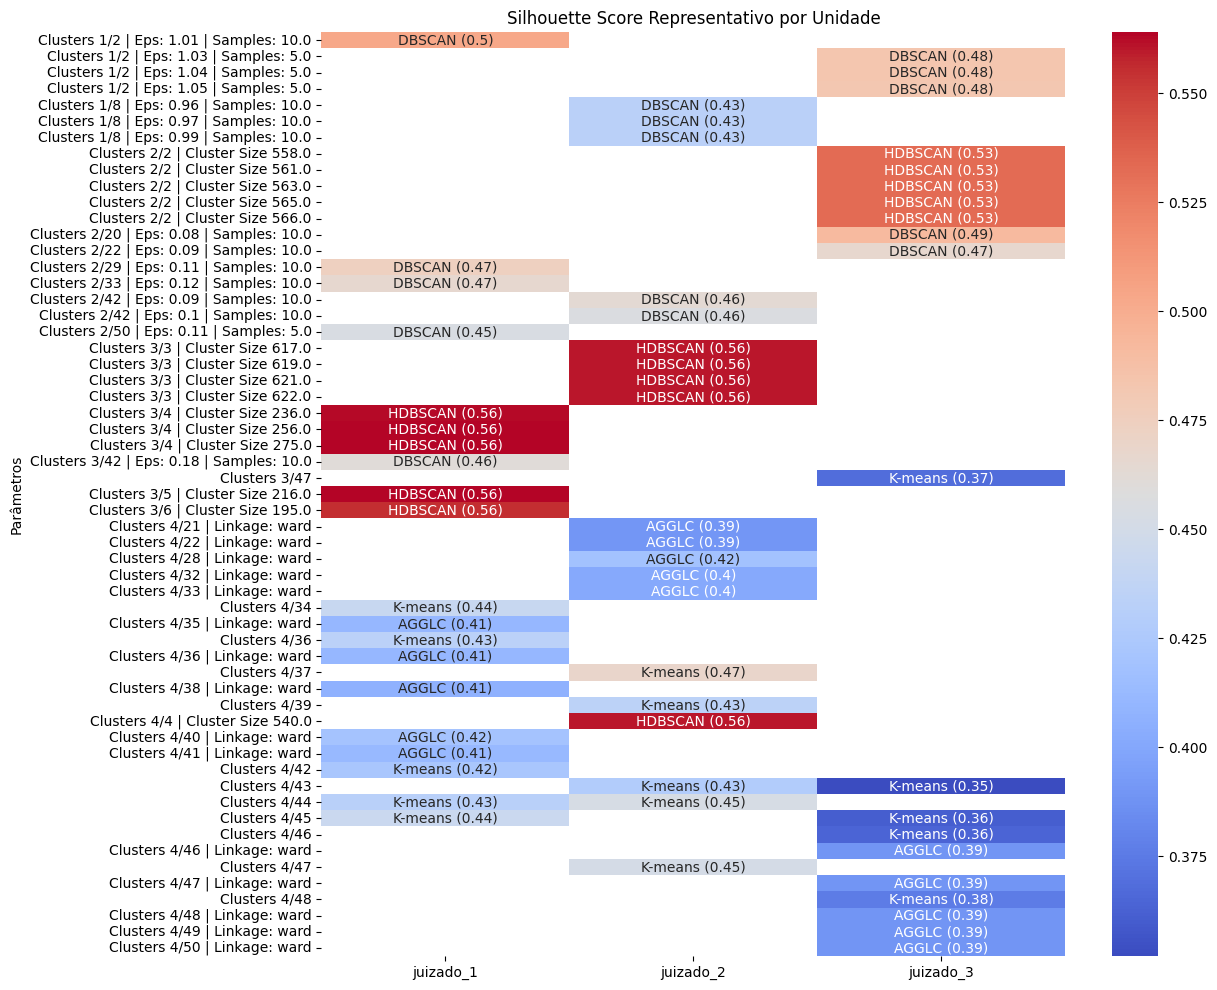

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

unidades = all_top_5["unidade"].unique()

unidades_data = { x: [] for x in unidades }
data_texts = { x: [] for x in unidades }
index_list = []

for (params, algo), data in all_top_5.groupby(["params", "algo"]):
  for unidade in unidades:
    unidade_data = data[data["unidade"] == unidade]
    if len(unidade_data) > 0:
      unidade_val = unidade_data["best_silhouette"].values[0]
      unidades_data[unidade].append(unidade_val)
      data_texts[unidade].append(f"{algo} ({round(unidade_val, 2)})")
    else:
      unidades_data[unidade].append(None)
      data_texts[unidade].append("--")
  index_list.append(params)

table_data = pd.DataFrame(unidades_data)
table_name = pd.DataFrame(data_texts)
table_data.index = index_list
table_name.index = index_list

# Gerar o heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(table_data, annot=table_name, cmap='coolwarm', fmt="")
plt.title('Silhouette Score Representativo por Unidade')
plt.ylabel('Parâmetros')
plt.show()